<a href="https://colab.research.google.com/github/laoktaviana/DecisionTree-KDDcup/blob/main/V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Install python libraries

In [85]:
!pip install requests sklearn pandas numpy matplotlib seaborn > /dev/nul

2. Load libraries and declare vars

In [86]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

#File retrieved from the UNB/UCI site 
kdd99_names_url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names'
training_attack_types ='http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types'
kdd99_20p_filename = 'KDDTrain+_20Percent.csv'
kdd99_20p_url = "https://gist.githubusercontent.com/sblack4/3a34ebf5a8f02629f3f5ab8547c2f85f/raw/1985460fe1b036c28c0235871c6e770409be4e5b/KDDTrain+_20Percent.csv"

3. Download remaning file

In [87]:
#Download file containing the column names and map of the attacks also their type
def dl_file(url):
  filename = os.path.basename(url)
  with open(filename, 'wb') as fh:
    r = requests.get(url)
    fh.write(r.content)
  return filename

files_to_dl = [kdd99_names_url, training_attack_types, kdd99_20p_url]

list(map(dl_file, files_to_dl))

['kddcup.names', 'training_attack_types', 'KDDTrain+_20Percent.csv']

4. View file contents



In [88]:
!head KDDTrain+_20Percent.txt
#The head command is used to quickly get these first few from through the shell. 

head: cannot open 'KDDTrain+_20Percent.txt' for reading: No such file or directory


In [89]:
!head kddcup.names

back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster.
duration: continuous.
protocol_type: symbolic.
service: symbolic.
flag: symbolic.
src_bytes: continuous.
dst_bytes: continuous.
land: symbolic.
wrong_fragment: continuous.
urgent: continuous.


In [90]:
!head training_attack_types

back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l
ipsweep probe
land dos
loadmodule u2r
multihop r2l
neptune dos


5. Load labels and data

In [91]:
#The first file
with open('kddcup.names', 'r') as fh:
  fh.readline() # get rid of the first line
  lines = fh.readlines()

col_names = []
for line in lines:
  name = line.split(':')[0]
  col_names.append(name)

# the last one is the target, attack_type
col_names.append('attack_type')
col_names.append('successfulPredictions')

In [92]:
#Fig1. Column Names
for nm in col_names: print('  - ' + nm)

  - duration
  - protocol_type
  - service
  - flag
  - src_bytes
  - dst_bytes
  - land
  - wrong_fragment
  - urgent
  - hot
  - num_failed_logins
  - logged_in
  - num_compromised
  - root_shell
  - su_attempted
  - num_root
  - num_file_creations
  - num_shells
  - num_access_files
  - num_outbound_cmds
  - is_host_login
  - is_guest_login
  - count
  - srv_count
  - serror_rate
  - srv_serror_rate
  - rerror_rate
  - srv_rerror_rate
  - same_srv_rate
  - diff_srv_rate
  - srv_diff_host_rate
  - dst_host_count
  - dst_host_srv_count
  - dst_host_same_srv_rate
  - dst_host_diff_srv_rate
  - dst_host_same_src_port_rate
  - dst_host_srv_diff_host_rate
  - dst_host_serror_rate
  - dst_host_srv_serror_rate
  - dst_host_rerror_rate
  - dst_host_srv_rerror_rate
  - attack_type
  - successfulPredictions


In [93]:
#The second file
#This mapping reduce the 23 attacks to 4 types of attacks. 
with open('training_attack_types', 'r') as fh:
  lines = fh.readlines()

print('-'*24)
print(f'{"Attack ".rjust(16, " ")}-> type')
print('-'*24)
attack_types = {}
for line in lines:
  line = line.replace('\n', '')
  if not line: continue
  typ = line.split(' ')[0]
  cls = line.split(' ')[1]
  attack_types[typ] = cls

------------------------
         Attack -> type
------------------------


In [94]:
#Not just records of attacks but also records of a normal state for system
for typ, cls in attack_types.items(): print(f'{typ.ljust(16, " ")}-> {cls}')

back            -> dos
buffer_overflow -> u2r
ftp_write       -> r2l
guess_passwd    -> r2l
imap            -> r2l
ipsweep         -> probe
land            -> dos
loadmodule      -> u2r
multihop        -> r2l
neptune         -> dos
nmap            -> probe
perl            -> u2r
phf             -> r2l
pod             -> dos
portsweep       -> probe
rootkit         -> u2r
satan           -> probe
smurf           -> dos
spy             -> r2l
teardrop        -> dos
warezclient     -> r2l
warezmaster     -> r2l


6. Creat DataFrame from labels and data

In [95]:
#load data file
#pandas library used to read file into a DataFrame with the column names that was list above. 
#attack_type is appended as the attack type
kdd99_20p_df = pd.read_csv(kdd99_20p_filename, names=col_names, index_col=None)

kdd99_20p_df['attack_class'] = kdd99_20p_df.apply(
    lambda x: 'normal' if x['attack_type'] == 'normal' else attack_types[x['attack_type']], 
    axis=1)

In [96]:
#The first five lines at the head of the DataFrame
kdd99_20p_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,successfulPredictions,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal


--------------------------------

1. Data statistic



In [97]:
#General shape of the sataset by rows, cols
kdd99_20p_df.shape

(25192, 44)

In [98]:
#Descriptive statistics for all numerical columns in dataset
kdd99_20p_df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,successfulPredictions
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.0,25192.0,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,0.001548,0.001350,0.249841,0.014727,0.000357,0.004327,0.0,0.0,0.009130,84.591180,27.698754,0.286338,0.283762,0.118630,0.120260,0.660559,0.062363,0.095931,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769,19.487695
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,0.039316,0.048785,11.500842,0.529602,0.018898,0.098524,0.0,0.0,0.095115,114.673451,72.468242,0.447312,0.447599,0.318745,0.322335,0.439637,0.178550,0.256583,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333,2.328541
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,144.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,1.000000,2.000000,975.000000,40.000000,1.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [99]:
#Description of categorical variables
#Refreshing chart showing some of the variables are investigated further with two charts showing the distributions for the attack types 
kdd99_20p_df.describe(include=['object'])

,protocol_type,service,flag,attack_type,attack_class
count,25192,25192,25192,25192,25192
unique,3,66,11,22,5
top,tcp,http,SF,normal,normal
freq,20526,8003,14973,13449,13449


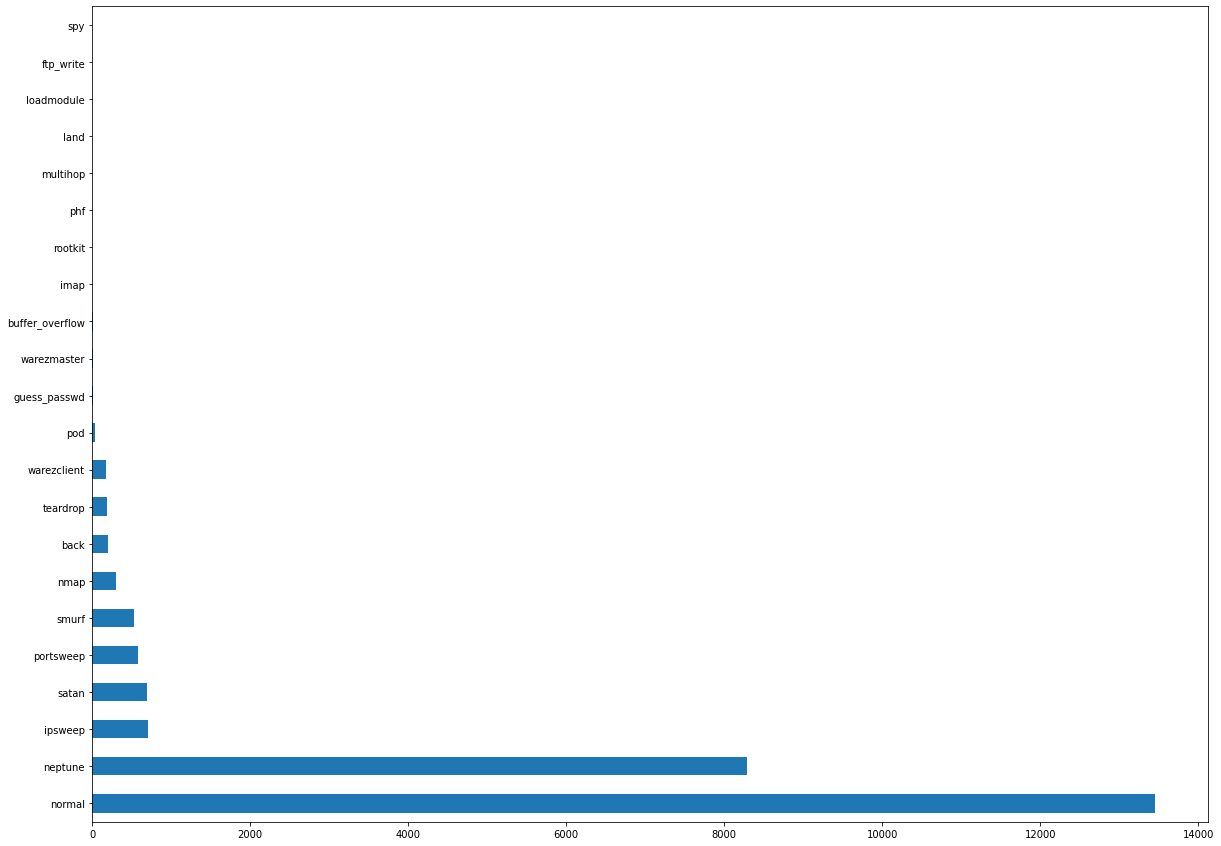

In [100]:
#Bar graph of attack type
#The largest class= normal
#The attack type= neptune
fig = plt.figure()
fig = kdd99_20p_df['attack_type'].value_counts().plot(figsize=(20, 15), kind="barh")
plt.show()

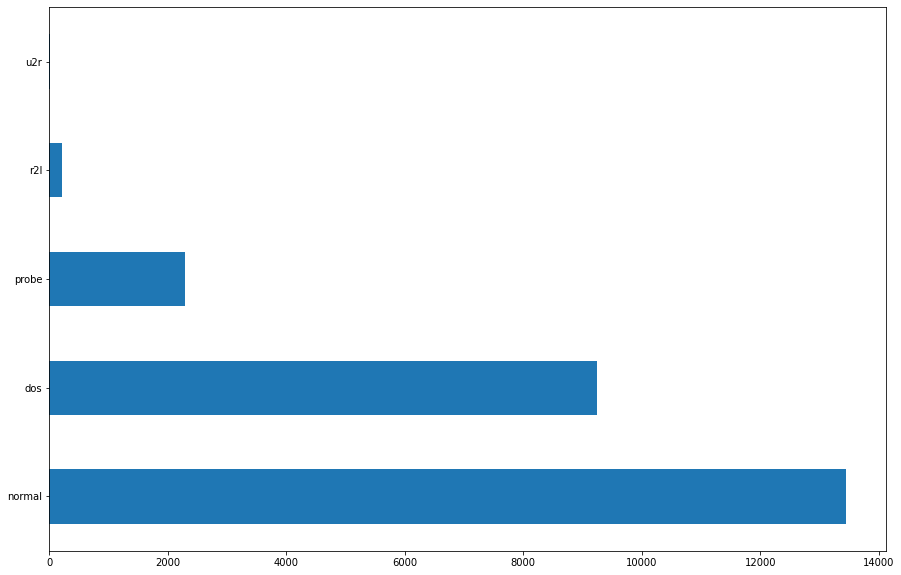

In [101]:
#Bar attack-class classification
plt.figure(figsize=(15, 10))
kdd99_20p_df['attack_class'].value_counts().plot(kind="barh")
plt.show()

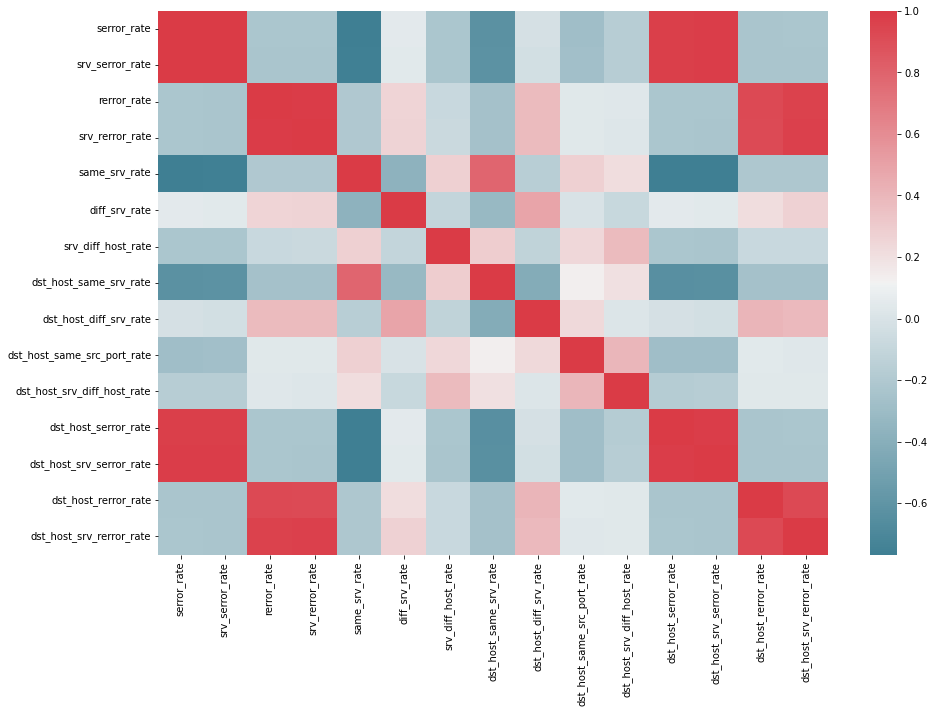

In [102]:
#Pairwise correlation for float point type values
#Convariance between numerical features. 
corr = kdd99_20p_df.loc[:,kdd99_20p_df.dtypes == 'float64'].corr()

plt.figure(figsize = (15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True))

2. Engineering Data

In [103]:
#Binary classification of dataset
#Dataset was further classified into binary types of attack or not attack (normal). This column was appeded to DataFrame
kdd99_20p_df['attack_biclass'] = kdd99_20p_df.apply(
    lambda x: 'normal' if x['attack_type'] == 'normal' else 'attack', 
    axis=1)

In [104]:
#Remove highly correlated features because make unctable decisions trees.
kdd99_20p_dropped = kdd99_20p_df.drop(['srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate'], axis=1)
kdd99_20p_dropped = kdd99_20p_dropped.drop(['attack_type', 'attack_biclass', 'successfulPredictions'], axis=1)

3. Data sampling

In [105]:
#Three sample: Random Sample, Uniform Distribution, Tree Sample
#Each sample contains 400 elements
n_sample = 100
random_sample = kdd99_20p_dropped.sample(n_sample)
uniform_sample = kdd99_20p_dropped.groupby('attack_class', group_keys=False)\
                                  .apply(lambda x: x.sample(int(n_sample/4), replace=True))
test_sample = kdd99_20p_dropped.sample(n_sample)

In [106]:
#Randome sample attack classes
random_sample.attack_class.value_counts()

normal    56
dos       31
probe     13
Name: attack_class, dtype: int64

In [107]:
#Uniform sample attack classes
uniform_sample.attack_class.value_counts()

u2r       25
probe     25
normal    25
dos       25
r2l       25
Name: attack_class, dtype: int64

In [108]:
#Test sample attack classes
test_sample.attack_class.value_counts()

normal    53
dos       39
probe      8
Name: attack_class, dtype: int64

4. Data analysis and results

In [109]:
#Creating decision trees
#function was two dataframes and compute decision tree information. 

from sklearn import metrics #Used to generate and graph decisionn tree

def make_tree(train_df, test_df, export_depth=2):
  ''' create, plot, score, and retrun tree '''

  y_train = random_sample['attack_class']
  x_train = random_sample.select_dtypes(exclude='object')

  y_test = test_df['attack_class']
  x_test = test_df.select_dtypes(exclude='object')

  dtc = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=16)
  dtc.fit(x_train, y_train)

  #Confusion matrix printed below the graphical representation of the decision tree
  #Confussion matrix allows assessment of our predictor on a class-level
  print(f'The test score is {dtc.score(x_test, y_test)}') 
  plt.figure(figsize=(15,10))
  plot_tree(dtc, class_names=dtc.classes_, feature_names=x_train.columns, filled=True, 
            fontsize=10, max_depth=2, precision=1, label=None, impurity=False)
  
  cm = metrics.plot_confusion_matrix(dtc, x_test, y_test)
  cm.figure_.suptitle("Confusion Matrix")

  plt.show()
  return export_text(dtc, feature_names=list(x_train.columns), max_depth=export_depth)

The test score is 0.86


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


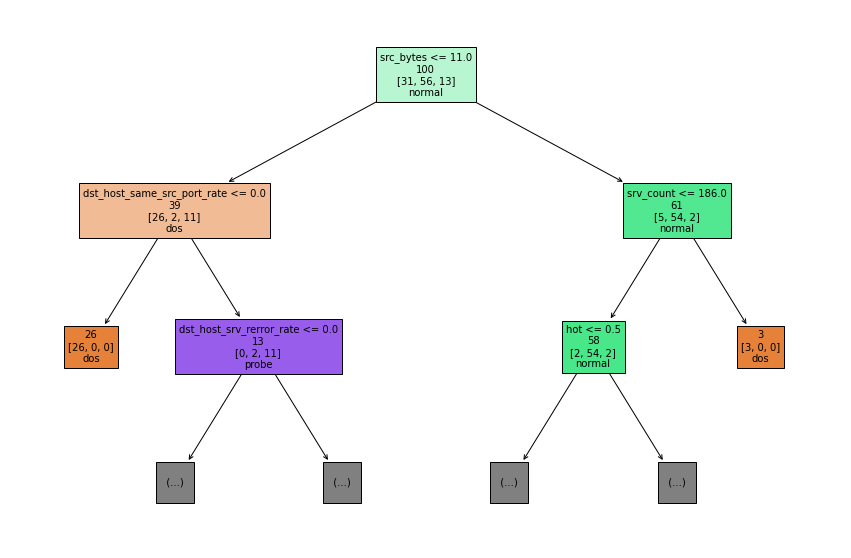

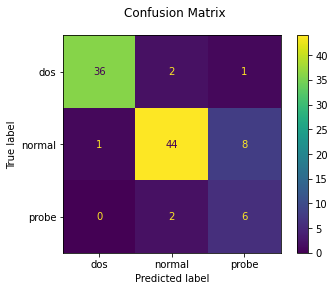

In [110]:
#Decision tree for random sample with confusion matrix
random_txt = make_tree(random_sample, test_sample)

The test score is 0.86


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


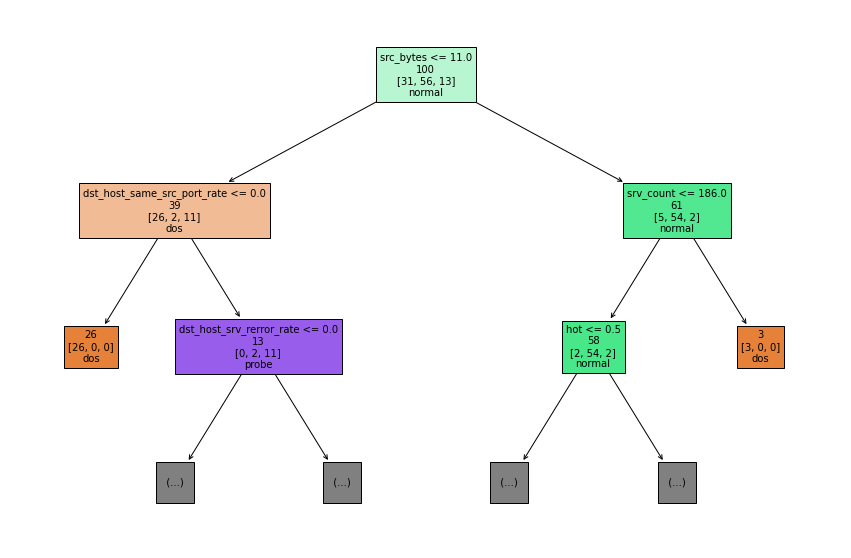

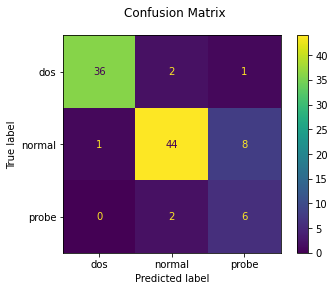

In [111]:
#Decision tree for uniform sample with confusion matrix
uni_txt = make_tree(uniform_sample, test_sample)

------------------


5. Conclusion

Table show are not the full from the trees but here is a tree truncated to 2 nodes past root. These two trees are very much alike, identically, and hight-level. 




In [112]:
#Side-by-side comparison of decision trees
import difflib #Create side-by-side comparison for two tree
from IPython.core.display import display, HTML
d = difflib.HtmlDiff().make_table(random_txt.split('\n'), uni_txt.split('\n'),
                                   fromdesc='Tree1', todesc='Tree2')
HTML(d)